In [156]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
df=pd.read_csv("insurance.csv")
df.shape

(1338, 7)

In [158]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [160]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [161]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [162]:
df.duplicated().sum()

np.int64(1)

In [163]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [164]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).sum()
print("Outliers in each column:")
print(outliers)

Outliers in each column:
age           0
bmi           9
children      0
charges     139
dtype: int64


In [165]:
cols_to_cap = ['bmi', 'charges']

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col} has {len(outliers_after)} outliers after capping\n")


bmi has 0 outliers after capping

charges has 0 outliers after capping



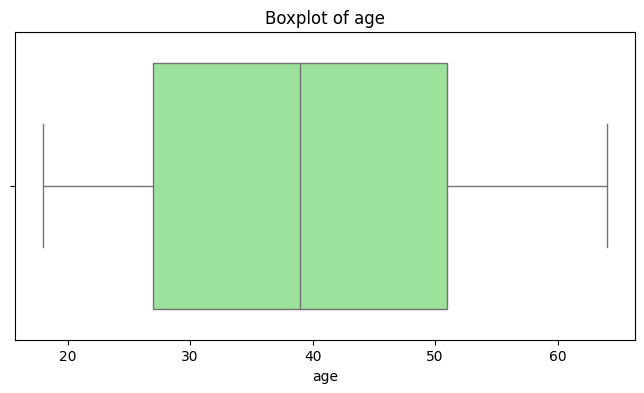

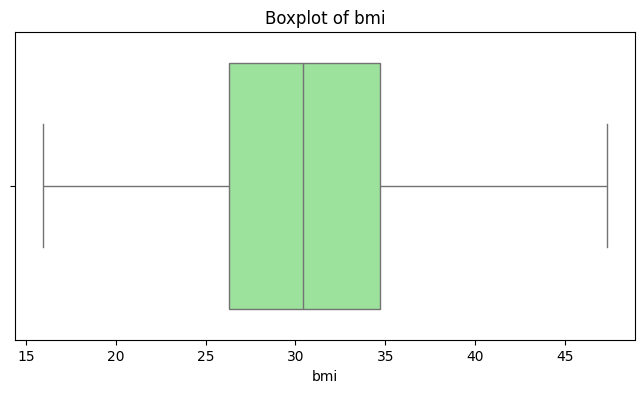

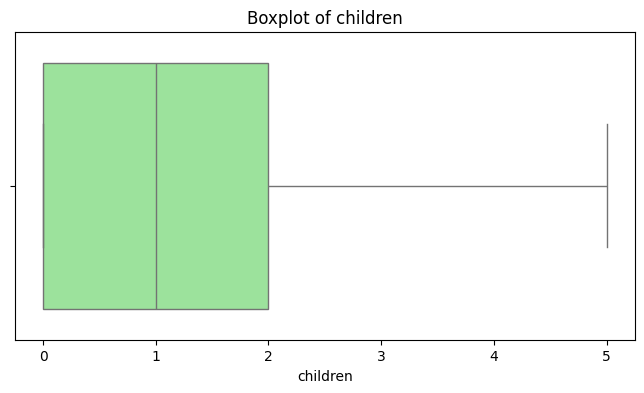

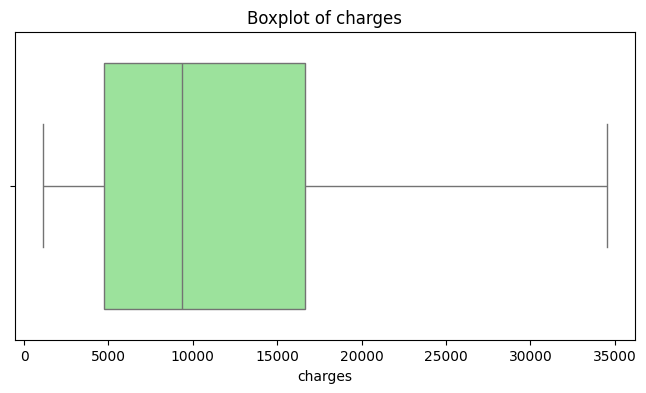

In [166]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [167]:
print(df.skew(numeric_only=True))
df['charges'] = np.log1p(df['charges'])  # log(1 + x) to handle 0 values if any
df['children'] = np.log1p(df['children'])

print(df[['charges', 'children']].skew())





age         0.054781
bmi         0.232892
children    0.937421
charges     1.084697
dtype: float64
charges    -0.222785
children    0.262813
dtype: float64


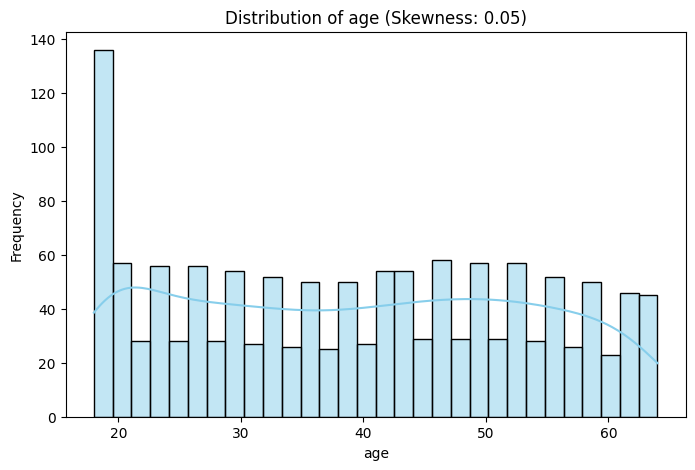

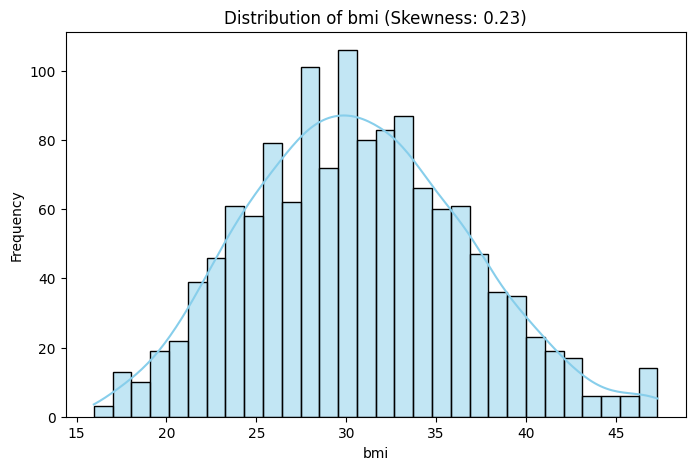

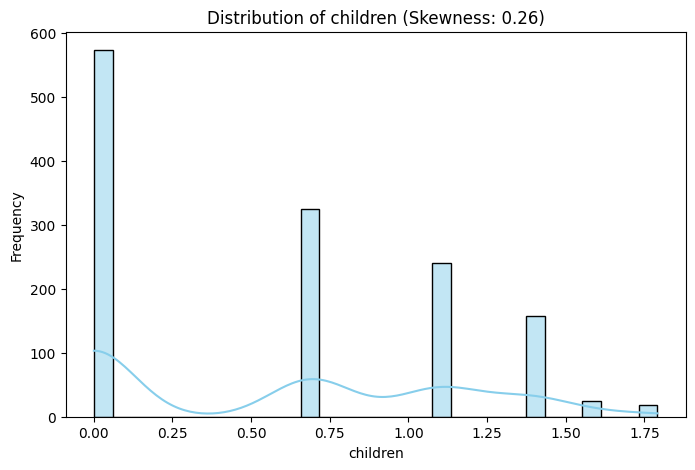

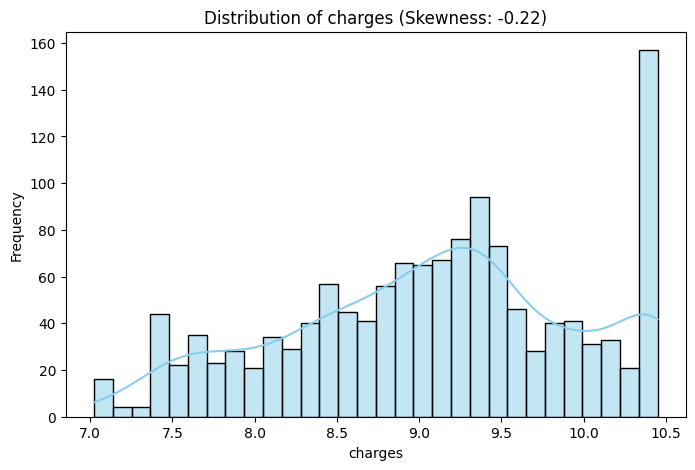

In [168]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col} (Skewness: {df[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

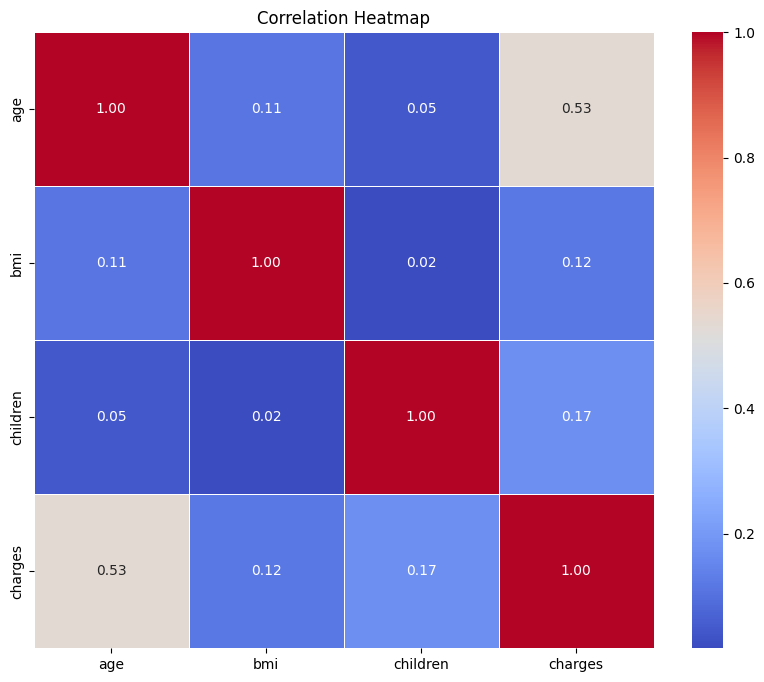

In [169]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [170]:
# ==============================
# Insurance Cost Prediction - Full Notebook
# ==============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pickle

# --- Step 1: Load Dataset ---
df = pd.read_csv("insurance.csv")

# --- Step 2: Handle duplicates ---
df = df.drop_duplicates()

# --- Step 3: Log transformation of skewed columns ---
df['charges'] = np.log1p(df['charges'])
df['children'] = np.log1p(df['children'])

# --- Step 4: Define Features and Target ---
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

X = df[categorical_cols + numerical_cols]
y = df['charges']

# --- Step 5: One-hot encoding ---
X = pd.get_dummies(X, drop_first=True)

# --- Step 6: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Step 7: Scaling numerical features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 8: Define models ---
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(),
    "LassoCV": LassoCV(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "XGBRegressor": XGBRegressor(random_state=42, objective='reg:squarederror')
}

# --- Step 9: Train and Evaluate (log-transformed target) ---
results_log = {}
results_original = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # --- Metrics on log-transformed target ---
    r2_log = r2_score(y_test, y_pred)
    mse_log = mean_squared_error(y_test, y_pred)
    rmse_log = np.sqrt(mse_log)
    results_log[name] = {"R2_log": r2_log, "MSE_log": mse_log, "RMSE_log": rmse_log}
    
    # --- Metrics on original scale ---
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    r2_orig = r2_score(y_test_original, y_pred_original)
    mse_orig = mean_squared_error(y_test_original, y_pred_original)
    rmse_orig = np.sqrt(mse_orig)
    results_original[name] = {"R2_orig": r2_orig, "MSE_orig": mse_orig, "RMSE_orig": rmse_orig}

# --- Step 10: Convert results to DataFrames ---
results_log_df = pd.DataFrame(results_log).T.sort_values(by='R2_log', ascending=False)
results_original_df = pd.DataFrame(results_original).T.sort_values(by='R2_orig', ascending=False)

print("\n=== Metrics on Log-Transformed Target ===")
print(results_log_df)

# --- Save models and scaler ---
pickle.dump(scaler, open('insurance_scaler.pkl', 'wb'))
pickle.dump(models, open('insurance_models.pkl', 'wb'))

# --- Save feature columns for app.py ---
columns_list = X.columns.tolist()
pickle.dump(columns_list, open('insurance_columns.pkl', 'wb'))


=== Metrics on Log-Transformed Target ===
                    R2_log   MSE_log  RMSE_log
SVR               0.886831  0.105008  0.324049
GradientBoosting  0.877865  0.113328  0.336642
RandomForest      0.841638  0.146943  0.383331
LinearRegression  0.831377  0.156463  0.395554
RidgeCV           0.831281  0.156552  0.395667
LassoCV           0.831045  0.156771  0.395943
XGBRegressor      0.809724  0.176555  0.420184
DecisionTree      0.699696  0.278648  0.527871
